In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

## Load and PreProcess Data

2024-07-05 16:37:02.590098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 16:37:02.590252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 16:37:02.722768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


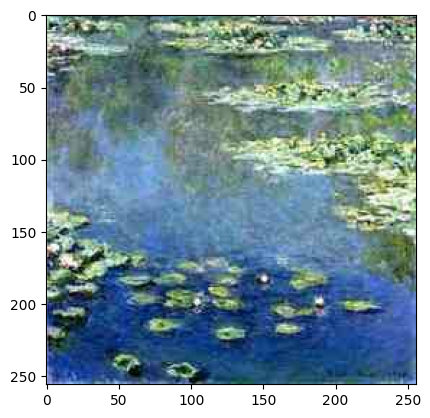

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Set constants
IMG_SIZE = (256, 256)
BATCH_SIZE = 1
BUFFER_SIZE = 1000

# Load JPEG images
def load_image(file_path):
    img = load_img(file_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1] range
    return img

# Create dataset
def create_dataset(file_paths):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(lambda x: tf.numpy_function(load_image, [x], tf.float32))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

# Get file paths
monet_file_paths = [os.path.join('/kaggle/input/gan-getting-started/monet_jpg', filename) for filename in os.listdir('/kaggle/input/gan-getting-started/monet_jpg')]
photo_file_paths = [os.path.join('/kaggle/input/gan-getting-started/photo_jpg', filename) for filename in os.listdir('/kaggle/input/gan-getting-started/photo_jpg')]

# Create datasets
monet_dataset = create_dataset(monet_file_paths)
photo_dataset = create_dataset(photo_file_paths)

# Check the first image
for img in monet_dataset.take(1):
    plt.imshow((img[0] + 1) / 2.0)  # Rescale to [0, 1] range for display
    plt.show()

## Build CycleGan Model

In [4]:
from tensorflow.keras import layers

# Define the generator
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')
    ]
    
    up_stack = [
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')
    ]
    
    x = inputs
    for down in down_stack:
        x = down(x)
    
    for up in up_stack:
        x = up(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# Define the discriminator
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (4, 4), strides=2, padding='same')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# Instantiate the models
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

## Compile and Train CycleGAN Model

In [5]:
# Define loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

# Training loop
import time

EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()
    
    for image_x, image_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        train_step(image_x, image_y)
    
    print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec')

# Save the generator model
generator_g.save('generator_g.h5')

Time taken for epoch 1 is 33.07 sec
Time taken for epoch 2 is 18.00 sec
Time taken for epoch 3 is 18.25 sec
Time taken for epoch 4 is 18.53 sec
Time taken for epoch 5 is 19.12 sec
Time taken for epoch 6 is 19.18 sec
Time taken for epoch 7 is 18.58 sec
Time taken for epoch 8 is 18.84 sec
Time taken for epoch 9 is 19.00 sec
Time taken for epoch 10 is 18.85 sec
Time taken for epoch 11 is 18.67 sec
Time taken for epoch 12 is 18.71 sec
Time taken for epoch 13 is 18.82 sec
Time taken for epoch 14 is 18.79 sec
Time taken for epoch 15 is 18.97 sec
Time taken for epoch 16 is 18.89 sec
Time taken for epoch 17 is 18.78 sec
Time taken for epoch 18 is 18.64 sec
Time taken for epoch 19 is 18.88 sec
Time taken for epoch 20 is 18.74 sec


## Generate and Save Images

In [6]:
import zipfile
import cv2

# Create a directory to save the generated images
os.makedirs('/kaggle/working/images', exist_ok=True)

# Generate images
for i, img in enumerate(photo_dataset.take(7000)):  # Adjust the number based on your requirement
    generated_img = generator_g(img, training=False)[0].numpy()
    generated_img = (generated_img * 127.5 + 127.5).astype(np.uint8)
    
    img_path = f'/kaggle/working/images/img_{i + 1}.jpg'
    cv2.imwrite(img_path, cv2.cvtColor(generated_img, cv2.COLOR_RGB2BGR))

# Create a zip file
with zipfile.ZipFile('/kaggle/working/images.zip', 'w') as img_zip:
    for dirname, _, filenames in os.walk('/kaggle/working/images'):
        for filename in filenames:
            img_zip.write(os.path.join(dirname, filename), filename)